**Load Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import Levenshtein
import cv2
import re
import torch
import sys
from keras.applications.densenet import preprocess_input
import torch
!pip install wordcloud
from torch.utils.data import DataLoader, Dataset
import random
from torchvision import transforms
from PIL import Image
from wordcloud import WordCloud
!ls /kaggle/input/


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


bms-molecular-translation


**Data Preparation**

In [2]:
#Reading the content
train = pd.read_csv('/kaggle/input/bms-molecular-translation/train_labels.csv')
print(f'train.shape: {train.shape}')
train.head(10)

train.shape: (2424186, 2)


image_id                                              InChI
0  000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1  000019cc0cd2  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2  0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3  000026b49b7e  InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4  000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
5  000028818203  InChI=1S/C19H22Br2N2O2/c1-13(2)10-16(19(24)25)...
6  000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...
7  000035624718  InChI=1S/C21H21N5O2S/c1-15-7-8-18(17-5-4-11-22...
8  00003e900ef4  InChI=1S/C13H18N2O5S/c1-4-10(13(17)18)15-12(16...
9  000045d5fbf9  InChI=1S/C13H15BrN2O3/c1-7-5-15-6-9(7)12(17)16...

In [3]:
train_path = "/kaggle/input/bms-molecular-translation/train/{}/{}/{}/{}.png"
get_image_path = lambda image_id_details :train_path.format(image_id_details[0], image_id_details[1], image_id_details[2], image_id_details) 
train['image_path']=train['image_id'].apply(get_image_path)
print(train.loc[100].InChI)
print(train.loc[100])

InChI=1S/C18H28N4O/c1-13-11-22(12-15-6-4-3-5-7-15)9-8-17(13)20-18(23)16-10-19-21-14(16)2/h3-7,13-14,16-17,19,21H,8-12H2,1-2H3,(H,20,23)
image_id                                           0002f0127691
InChI         InChI=1S/C18H28N4O/c1-13-11-22(12-15-6-4-3-5-7...
image_path    /kaggle/input/bms-molecular-translation/train/...
Name: 100, dtype: object


**Preparing INCHI Formulas for Extracting Features**

In [4]:

# Split the 'InChI' column into a list of components
train['InChI_Columns'] = train['InChI'].progress_apply(lambda x: x.split('/'))

# Calculate the length of the 'InChI_Columns' for each row
train['InChI_Len'] = train['InChI_Columns'].progress_apply(len)

InChI_new_df = train['InChI_Columns'].progress_apply(pd.Series)

# Concatenate 'InChI_df' with the original 'train' DataFrame
train = pd.concat([train, InChI_new_df.add_prefix('InChI_Column')], axis=1)

# Extract additional components
train['molecular_formula'] = train['InChI'].progress_apply(lambda x: x.split('/')[1])
train['connectivity_layer'] = train['InChI'].progress_apply(lambda x: x.split('/')[2])

def extract_stereochemical_layer(InChI):
    components = InChI.split('/')
    if len(components) > 3:
        return components[3]
    else:
        return 'No Stereochemical Layer'

train['Stereochemical Layer'] = train['InChI'].progress_apply(extract_stereochemical_layer)

# Created a new column 'InChI_New' by combining the extracted components
train['InChI_New'] = train['molecular_formula'] + "/" + train['connectivity_layer'] + "/" + train['Stereochemical Layer']


  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

  0%|          | 0/2424186 [00:00<?, ?it/s]

In [5]:
train.head(10)

image_id                                              InChI  \
0  000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
1  000019cc0cd2  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...   
2  0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
3  000026b49b7e  InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...   
4  000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   
5  000028818203  InChI=1S/C19H22Br2N2O2/c1-13(2)10-16(19(24)25)...   
6  000029a61c01  InChI=1S/C17H10BrN3O/c18-14-7-3-1-5-11(14)9-12...   
7  000035624718  InChI=1S/C21H21N5O2S/c1-15-7-8-18(17-5-4-11-22...   
8  00003e900ef4  InChI=1S/C13H18N2O5S/c1-4-10(13(17)18)15-12(16...   
9  000045d5fbf9  InChI=1S/C13H15BrN2O3/c1-7-5-15-6-9(7)12(17)16...   

                                          image_path  \
0  /kaggle/input/bms-molecular-translation/train/...   
1  /kaggle/input/bms-molecular-translation/train/...   
2  /kaggle/input/bms-molecular-translation/train/...   
3  /kaggle/input/bms-molecular-translation/train/...   
4  /kaggle/input/bms-molecular-translation/train/...   
5  /kaggle/input/bms-molecular-translation/train/...   
6  /kaggle/input/bms-molecular-translation/train/...   
7  /kaggle/input/bms-molecular-translation/train/...   
8  /kaggle/input/bms-molecular-translation/train/...   
9  /kaggle/input/bms-molecular-translation/train/...   

                                       InChI_Columns  InChI_Len InChI_Column0  \
0  [InChI=1S, C13H20OS, c1-9(2)8-15-13-6-5-10(3)7...          4      InChI=1S   
1  [InChI=1S, C21H30O4, c1-12(22)25-14-6-8-20(2)1...          7      InChI=1S   
2  [InChI=1S, C24H23N5O4, c1-14-13-15(7-8-17(14)2...          4      InChI=1S   
3  [InChI=1S, C17H24N2O4S, c1-12(20)18-13(14-7-6-...          4      InChI=1S   
4  [InChI=1S, C10H19N3O2S, c1-15-10(14)12-8-4-6-1...          4      InChI=1S   
5  [InChI=1S, C19H22Br2N2O2, c1-13(2)10-16(19(24)...          4      InChI=1S   
6  [InChI=1S, C17H10BrN3O, c18-14-7-3-1-5-11(14)9...          5      InChI=1S   
7  [InChI=1S, C21H21N5O2S, c1-15-7-8-18(17-5-4-11...          4      InChI=1S   
8  [InChI=1S, C13H18N2O5S, c1-4-10(13(17)18)15-12...          4      InChI=1S   
9  [InChI=1S, C13H15BrN2O3, c1-7-5-15-6-9(7)12(17...          7      InChI=1S   

   InChI_Column1                                      InChI_Column2  \
0       C13H20OS            c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14   
1       C21H30O4  c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-1...   
2     C24H23N5O4  c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-...   
3    C17H24N2O4S  c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(...   
4    C10H19N3O2S          c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16   
5  C19H22Br2N2O2  c1-13(2)10-16(19(24)25)23(9-8-14-6-4-3-5-7-14)...   
6    C17H10BrN3O  c18-14-7-3-1-5-11(14)9-12(10-19)16-20-15-8-4-2...   
7    C21H21N5O2S  c1-15-7-8-18(17-5-4-11-22-20(15)17)29(27,28)25...   
8    C13H18N2O5S  c1-4-10(13(17)18)15-12(16)9-5-7(2)8(3)11(6-9)2...   
9   C13H15BrN2O3  c1-7-5-15-6-9(7)12(17)16-11-3-2-8(13(18)19)4-1...   

                                       InChI_Column3  \
0                            h5-7,9,11,14H,8H2,1-4H3   
1                            h13-16,19H,4-11H2,1-3H3   
2                   h3-8,13H,9-12H2,1-2H3,(H2,25,31)   
3  h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21...   
4                  h8H,2-7H2,1H3,(H2,11,16)(H,12,14)   
5              h3-7,11-13,16H,8-10H2,1-2H3,(H,24,25)   
6                                           h1-9,13H   
7                    h2-8,11-12,16H,9-10,13-14H2,1H3   
8  h5-6,10H,4H2,1-3H3,(H,15,16)(H,17,18)(H2,14,19...   
9          h2-4,7,9,15H,5-6H2,1H3,(H,16,17)(H,18,19)   

                  InChI_Column4 InChI_Column5 InChI_Column6 InChI_Column7  \
0                           NaN           NaN           NaN           NaN   
1  t13-,14+,15+,16-,19-,20+,21+            m1            s1           NaN   
2                           NaN           NaN           NaN           NaN   
3                   

**Check for Duplicate Rows**

In [6]:
# Convert list columns to tuples
train['InChI_Columns'] = train['InChI_Columns'].apply(tuple)

# Use the duplicated() method to check for duplicate rows based on all columns
duplicates = train.duplicated(keep='first')

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = train[duplicates]

# Display the duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)


Duplicate Rows:
Empty DataFrame
Columns: [image_id, InChI, image_path, InChI_Columns, InChI_Len, InChI_Column0, InChI_Column1, InChI_Column2, InChI_Column3, InChI_Column4, InChI_Column5, InChI_Column6, InChI_Column7, InChI_Column8, InChI_Column9, InChI_Column10, molecular_formula, connectivity_layer, Stereochemical Layer, InChI_New]
Index: []


**Check for Missing Values**

In [7]:
# Check for missing data
missing_data = train.isnull().sum()
print(missing_data)


image_id                      0
InChI                         0
image_path                    0
InChI_Columns                 0
InChI_Len                     0
InChI_Column0                 0
InChI_Column1                 0
InChI_Column2                 0
InChI_Column3               307
InChI_Column4           1894009
InChI_Column5           2027632
InChI_Column6           2028030
InChI_Column7           2399869
InChI_Column8           2424031
InChI_Column9           2424158
InChI_Column10          2424185
molecular_formula             0
connectivity_layer            0
Stereochemical Layer          0
InChI_New                     0
dtype: int64


**Exploratory Data Analysis**

Exploratory Data Analysis for 'molecular_formula':
count        2424186
unique        329768
top       C15H22N2O2
freq            1391
Name: molecular_formula, dtype: object
Number of unique values: 329768
Sample values in 'molecular_formula':

1232085     C21H22N6O4
841182        C28H34O4
5510       C21H26N2O4S
1334242     C16H14FN3O
2043044    C14H14ClN3O
Name: molecular_formula, dtype: object


Exploratory Data Analysis for 'connectivity_layer':
count                                               2424186
unique                                              2359241
top       c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18(...
freq                                                     40
Name: connectivity_layer, dtype: object
Number of unique values: 2359241
Sample values in 'connectivity_layer':

1232085    c1-10-19-14(27-21(22)24-10)7-13(26-20(19)28)11...
841182     c1-4-25(31)10-7-21-8-12-27(20(3)13-21)28-15-26...
5510       c1-27-19-12-10-17(11-13-19)16-22-21(24)15-18-7...
1334242    

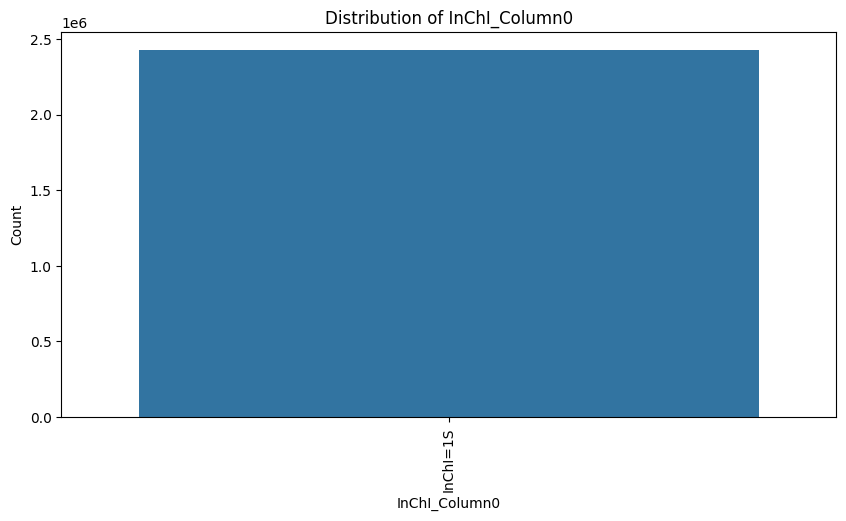



Exploratory Data Analysis for 'InChI_Column1':
count        2424186
unique        329768
top       C15H22N2O2
freq            1391
Name: InChI_Column1, dtype: object
Number of unique values: 329768
Sample values in 'InChI_Column1':

1232085     C21H22N6O4
841182        C28H34O4
5510       C21H26N2O4S
1334242     C16H14FN3O
2043044    C14H14ClN3O
Name: InChI_Column1, dtype: object


Exploratory Data Analysis for 'InChI_Column2':
count                                               2424186
unique                                              2359241
top       c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18(...
freq                                                     40
Name: InChI_Column2, dtype: object
Number of unique values: 2359241
Sample values in 'InChI_Column2':

1232085    c1-10-19-14(27-21(22)24-10)7-13(26-20(19)28)11...
841182     c1-4-25(31)10-7-21-8-12-27(20(3)13-21)28-15-26...
5510       c1-27-19-12-10-17(11-13-19)16-22-21(24)15-18-7...
1334242    c17-13-6-7-14(15(19)10-13)16(

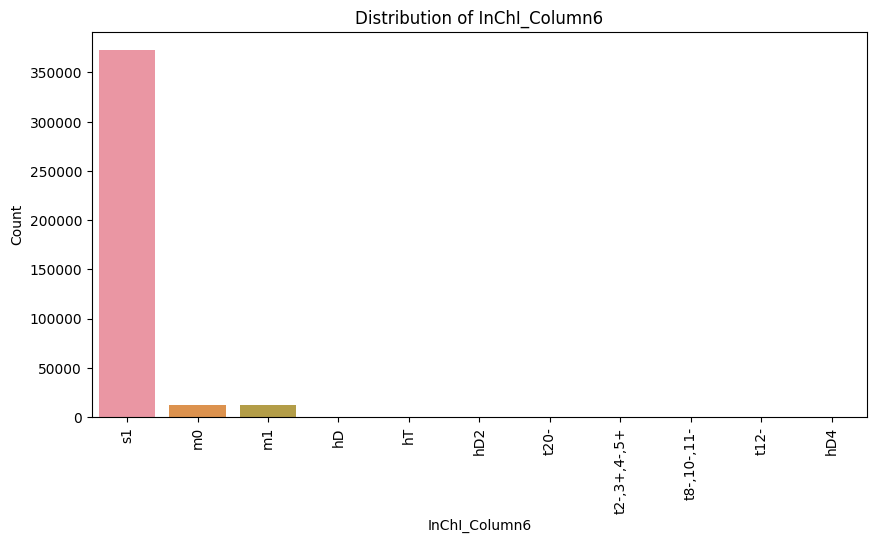



Exploratory Data Analysis for 'InChI_Column7':
count     24317
unique      385
top          s1
freq      23625
Name: InChI_Column7, dtype: object
Number of unique values: 385
Sample values in 'InChI_Column7':

1232085    NaN
841182     NaN
5510       NaN
1334242    NaN
2043044    NaN
Name: InChI_Column7, dtype: object


Exploratory Data Analysis for 'InChI_Column8':
count     155
unique    102
top        hD
freq       33
Name: InChI_Column8, dtype: object
Number of unique values: 102
Sample values in 'InChI_Column8':

1232085    NaN
841182     NaN
5510       NaN
1334242    NaN
2043044    NaN
Name: InChI_Column8, dtype: object


Exploratory Data Analysis for 'InChI_Column9':
count     28
unique     4
top       m1
freq      15
Name: InChI_Column9, dtype: object
Number of unique values: 4


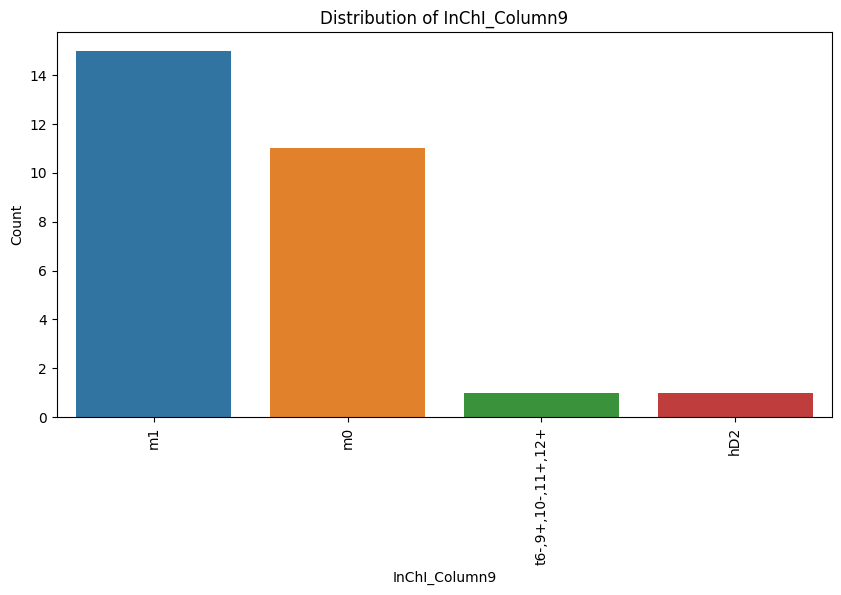



Exploratory Data Analysis for 'InChI_Column10':
count      1
unique     1
top       m0
freq       1
Name: InChI_Column10, dtype: object
Number of unique values: 1


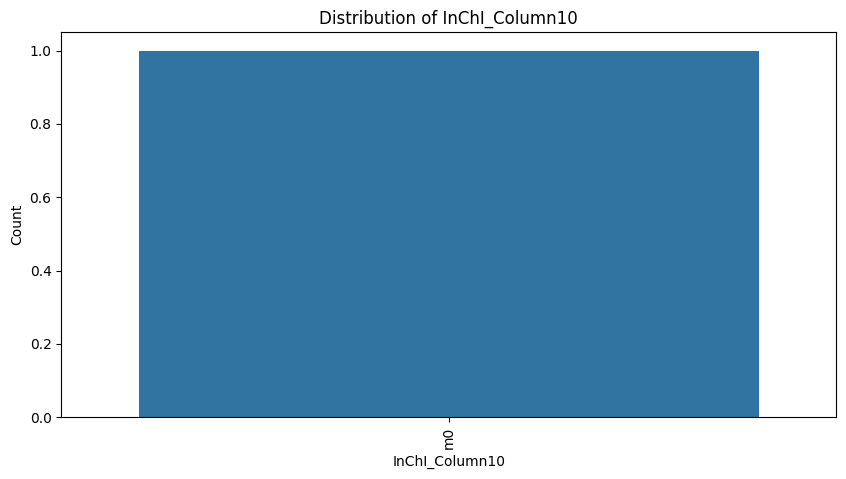

In [8]:
# Create a sample subset for faster exploration
sample_df = train.sample(frac=1.0, random_state=42)

# Function to perform EDA for a column
def perform_eda(column_name):
    print(f"Exploratory Data Analysis for '{column_name}':")
    
    # Summary statistics
    stats = sample_df[column_name].describe()
    print(stats)
    
    # Check unique values and their counts
    unique_values = sample_df[column_name].nunique()
    print(f"Number of unique values: {unique_values}")
    
    if unique_values <= 20:
        # Count plot for categorical columns with <= 20 unique values
        plt.figure(figsize=(10, 5))
        sns.countplot(data=sample_df, x=column_name, order=sample_df[column_name].value_counts().index)
        plt.xticks(rotation=90)
        plt.xlabel(column_name)
        plt.ylabel('Count')
        plt.title(f'Distribution of {column_name}')
        plt.show()
    else:
        # Display the first few rows of the column for inspection (for text data)
        print(f"Sample values in '{column_name}':\n")
        print(sample_df[column_name].head())
    
    print("\n" + "=" * 50 + "\n")

# Perform EDA for the specified columns
columns_to_eda = ['molecular_formula', 'connectivity_layer', 'Stereochemical Layer'] + [f'InChI_Column{i}' for i in range(11)]
for column_name in columns_to_eda:
    perform_eda(column_name)


**Fill Inchi Missing values with Mode**

In [9]:
# Columns to fill NaN values with mode
inchi_columns_to_fill = [f'InChI_Column{i}' for i in range(11)]

# Initialize the concatenated InChI string
concatenated_inchi = ''

# Iterate through the specified InChI columns
for column_name in inchi_columns_to_fill:
    # Find the mode value for the current InChI column
    mode_value = train[column_name].mode()[0]
    
    # Fill NaN values in the current InChI column with the mode value
    train[column_name].fillna(mode_value, inplace=True)
    
    # Append the mode value to the concatenated InChI string
    if mode_value != 'nan':
        if not concatenated_inchi:
            concatenated_inchi += mode_value
        else:
            concatenated_inchi += '/' + mode_value


In [10]:
missing_data = train.isnull().sum()
print(missing_data)


image_id                0
InChI                   0
image_path              0
InChI_Columns           0
InChI_Len               0
InChI_Column0           0
InChI_Column1           0
InChI_Column2           0
InChI_Column3           0
InChI_Column4           0
InChI_Column5           0
InChI_Column6           0
InChI_Column7           0
InChI_Column8           0
InChI_Column9           0
InChI_Column10          0
molecular_formula       0
connectivity_layer      0
Stereochemical Layer    0
InChI_New               0
dtype: int64


**Visualizations using Graph, WordCloud and Heat Map**

Advanced Exploratory Data Analysis for 'molecular_formula':


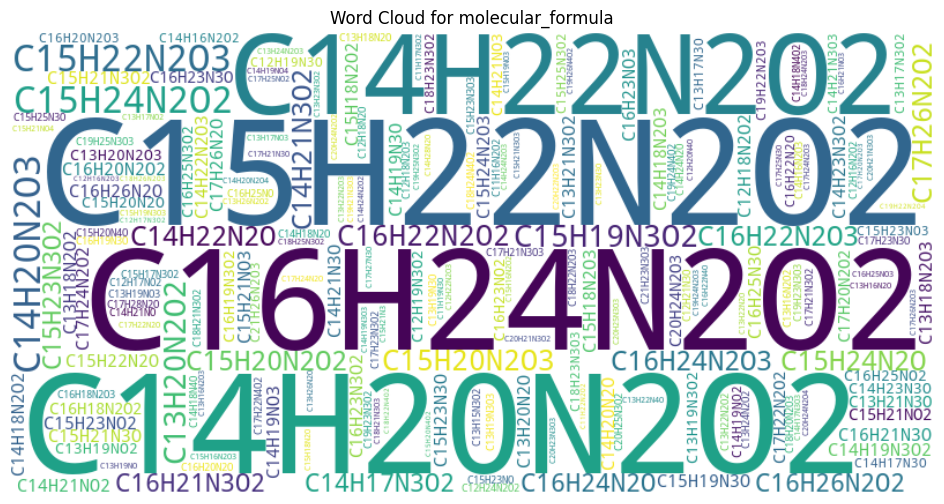

Advanced Exploratory Data Analysis for 'connectivity_layer':


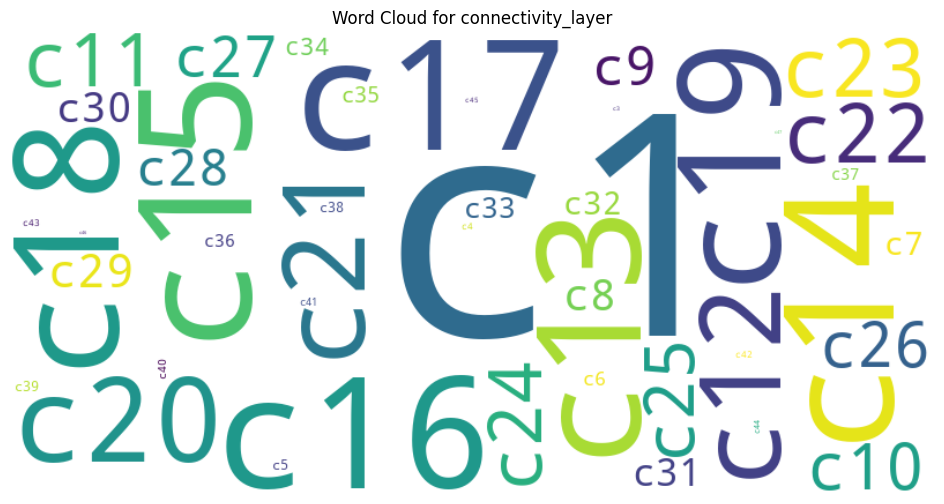

Advanced Exploratory Data Analysis for 'Stereochemical Layer':


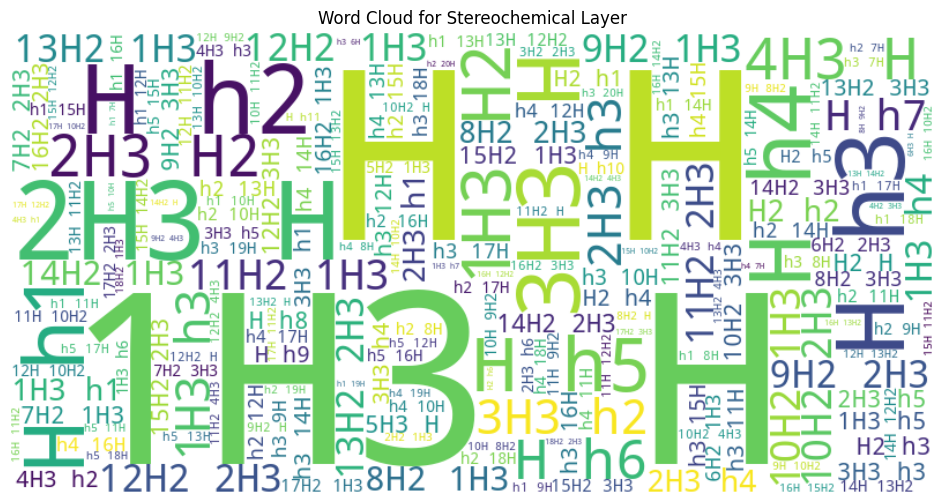

Advanced Exploratory Data Analysis for 'InChI_Column0':


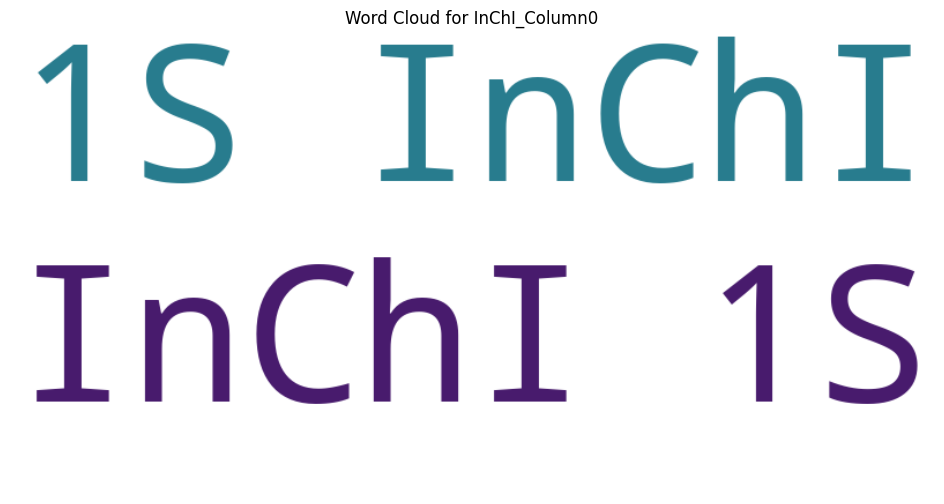

Advanced Exploratory Data Analysis for 'InChI_Column1':


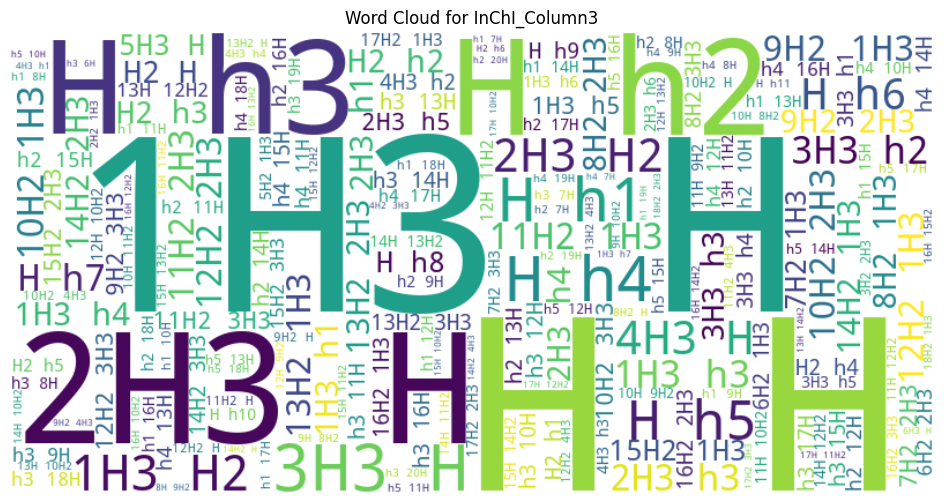

Advanced Exploratory Data Analysis for 'InChI_Column4':


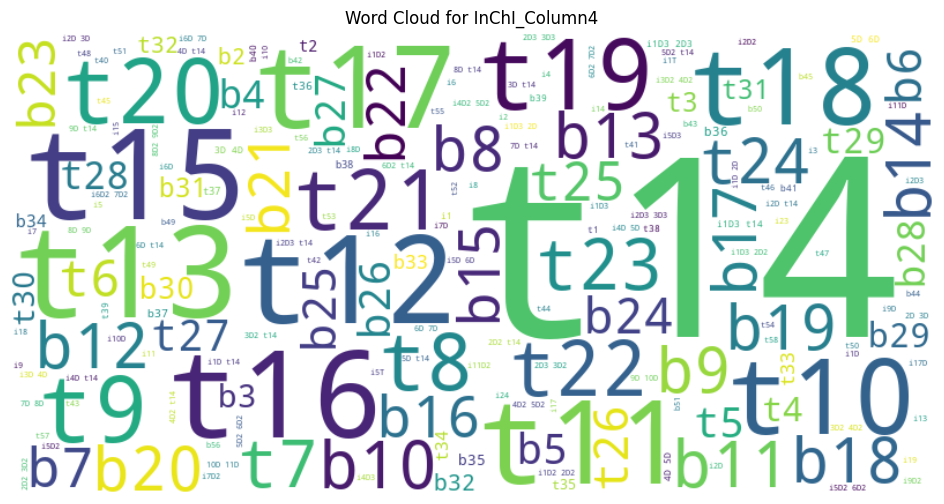

Advanced Exploratory Data Analysis for 'InChI_Column5':


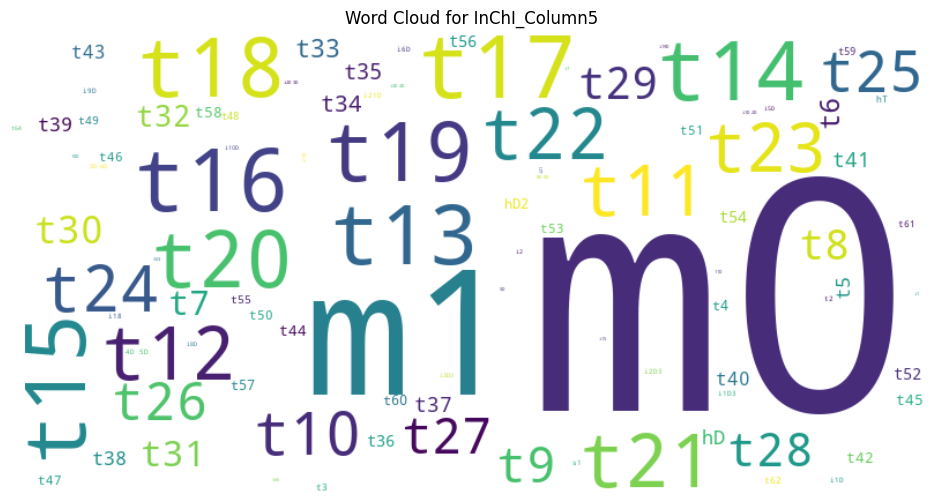

Advanced Exploratory Data Analysis for 'InChI_Column6':


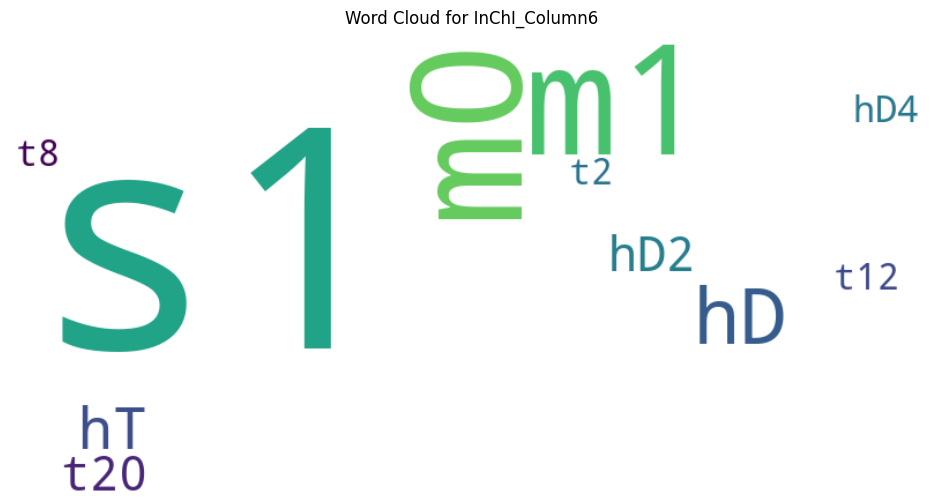

Advanced Exploratory Data Analysis for 'InChI_Column7':


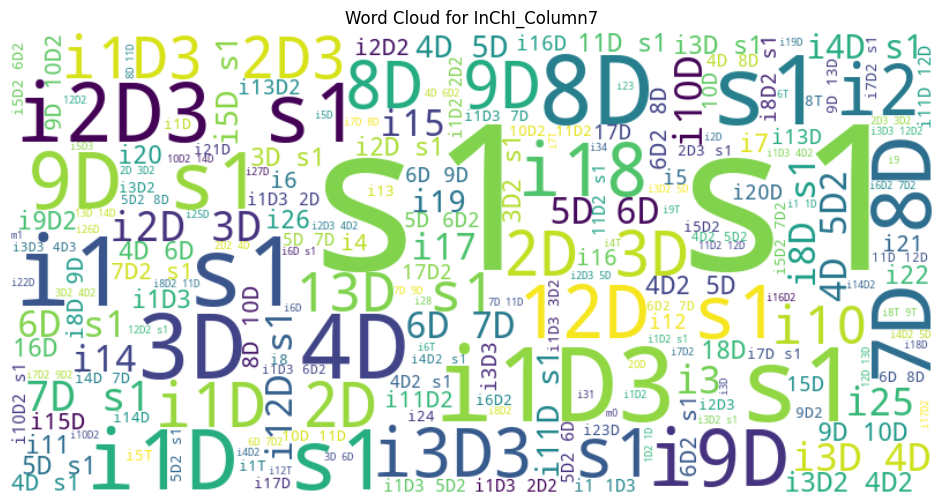

Advanced Exploratory Data Analysis for 'InChI_Column8':


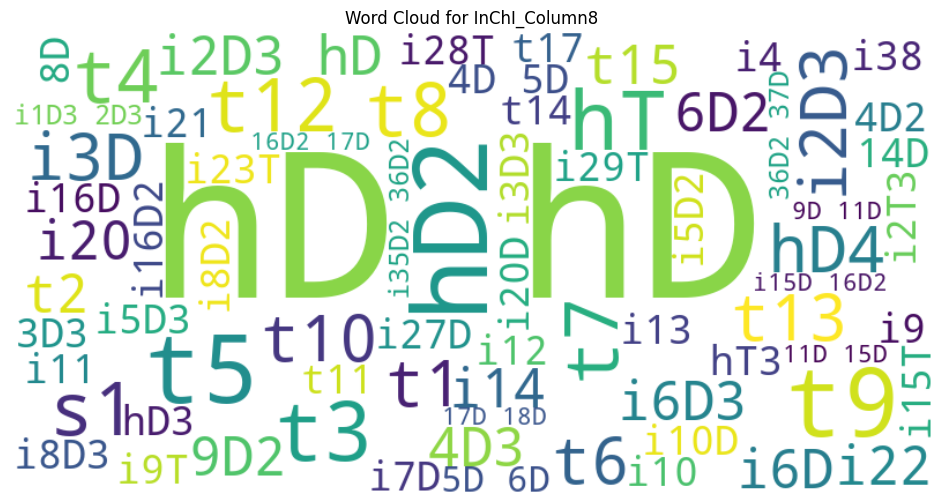

Advanced Exploratory Data Analysis for 'InChI_Column9':


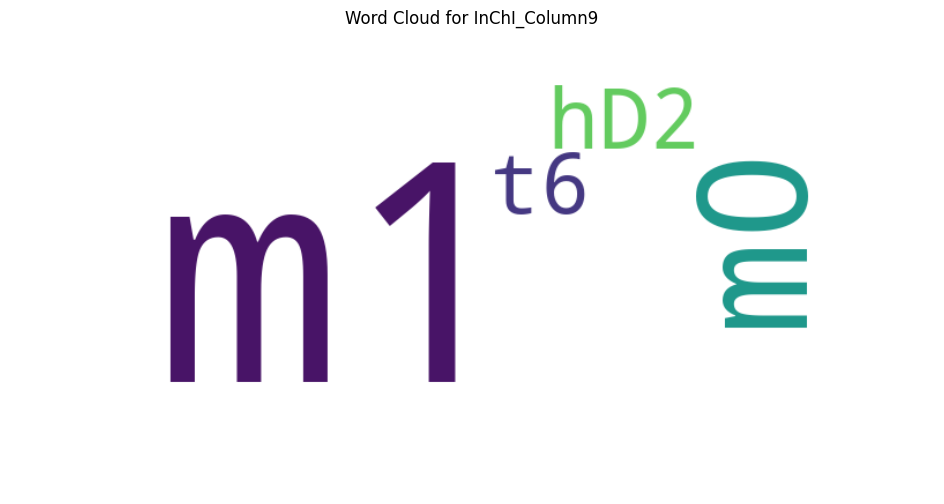

Advanced Exploratory Data Analysis for 'InChI_Column10':


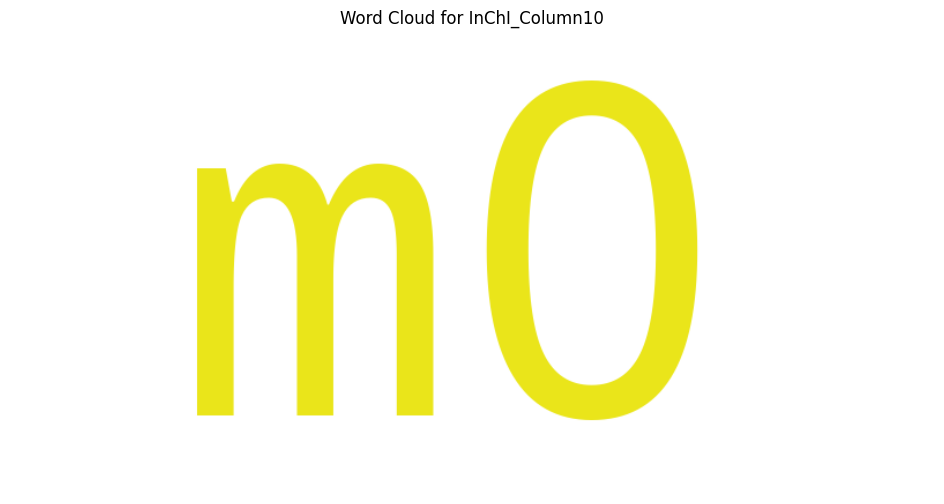

In [11]:
from wordcloud import WordCloud

# Function to perform advanced EDA for a column
def perform_advanced_eda(train, column_name):
    print(f"Advanced Exploratory Data Analysis for '{column_name}':")
    
    if column_name == 'InChI':
        # Special handling for 'InChI' column
        if train[column_name].dtype == 'object':
            # Sample word cloud for 'InChI' text column
            plt.figure(figsize=(12, 6))
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train[column_name]))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud for {column_name}')
            plt.show()
    elif train[column_name].dtype == 'object':
        # Sample word cloud for other text columns
        plt.figure(figsize=(12, 6))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train[column_name]))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {column_name}')
        plt.show()
    else:
        # Numerical data distribution visualization
        plt.figure(figsize=(12, 6))
        sns.histplot(train[column_name], bins=20, kde=True)
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {column_name}')
        plt.show()

# Perform advanced EDA for the specified columns, including 'InChI'
columns_to_eda = ['molecular_formula', 'connectivity_layer', 'Stereochemical Layer'] + [f'InChI_Column{i}' for i in range(11)]
for column_name in columns_to_eda:
    perform_advanced_eda(train, column_name)


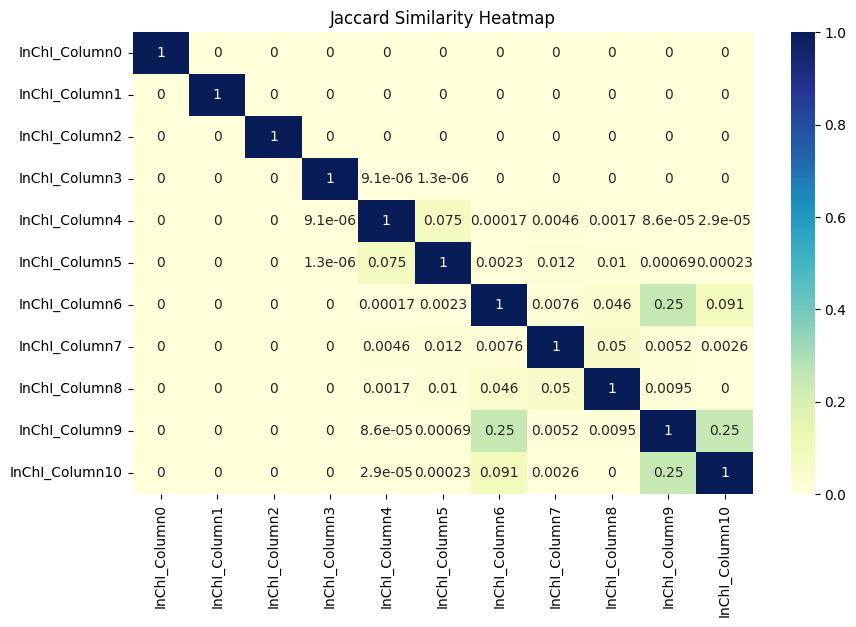

In [12]:
# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return intersection / union

# Create a similarity matrix
columns_to_compare = [f'InChI_Column{i}' for i in range(11)] 
similarity_matrix = pd.DataFrame(index=columns_to_compare, columns=columns_to_compare)

for col1 in columns_to_compare:
    for col2 in columns_to_compare:
        similarity = jaccard_similarity(set(train[col1]), set(train[col2]))
        similarity_matrix.loc[col1, col2] = similarity

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_matrix.astype(float), annot=True, cmap="YlGnBu")
plt.title("Jaccard Similarity Heatmap")
plt.show()


In [13]:
atom=['Cl', 'C','Br','B','Si','S' 'H', 'P', 'O', 'N', 'I', 'F']
atom_revised=['G', 'C','R','B','L','S' 'H', 'P', 'O', 'N', 'I', 'F']

# Define a function to revise elements in 'molecular_formula'
def revise_formula_element(formula):
    revised_formula = formula
    if "Cl" in formula:
        revised_formula = revised_formula.replace("Cl", "W")
    if "Br" in formula:
        revised_formula = revised_formula.replace("Br", "R")
    if "Si" in formula:
        revised_formula = revised_formula.replace("Si", "L")
    return revised_formula

# Apply the 'revise_formula_element' function to the 'molecular_formula' column
train['molecular_formula'] = train['molecular_formula'].apply(revise_formula_element)
 

In [14]:

# Define a function to extract the number of carbon atoms from 'molecular_formula'
def extract_carbon_count(formula):
    nums = {"0", "1", "2", "3", "4", "5", "6", "7", "8", "9"}
    result = ""
    for i in range(1, len(formula)):
        if formula[i] in nums:
            result += formula[i]
        else:
            if result:
                return int(result) 
            else:
                return 0  # Return 0 if there are no digits
    return int(result)  # Return the result if digits are found

# Apply the 'extract_carbon_count' function to create a new 'C' column
train['Total Carbon'] = train['molecular_formula'].apply(extract_carbon_count)

# Display the modified DataFrame
train.head()



image_id                                              InChI  \
0  000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
1  000019cc0cd2  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...   
2  0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
3  000026b49b7e  InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...   
4  000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   

                                          image_path  \
0  /kaggle/input/bms-molecular-translation/train/...   
1  /kaggle/input/bms-molecular-translation/train/...   
2  /kaggle/input/bms-molecular-translation/train/...   
3  /kaggle/input/bms-molecular-translation/train/...   
4  /kaggle/input/bms-molecular-translation/train/...   

                                       InChI_Columns  InChI_Len InChI_Column0  \
0  (InChI=1S, C13H20OS, c1-9(2)8-15-13-6-5-10(3)7...          4      InChI=1S   
1  (InChI=1S, C21H30O4, c1-12(22)25-14-6-8-20(2)1...          7      InChI=1S   
2  (InChI=1S, C24H23N5O4, c1-14-13-15(7-8-17(14)2...          4      InChI=1S   
3  (InChI=1S, C17H24N2O4S, c1-12(20)18-13(14-7-6-...          4      InChI=1S   
4  (InChI=1S, C10H19N3O2S, c1-15-10(14)12-8-4-6-1...          4      InChI=1S   

  InChI_Column1                                      InChI_Column2  \
0      C13H20OS            c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14   
1      C21H30O4  c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-1...   
2    C24H23N5O4  c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-...   
3   C17H24N2O4S  c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(...   
4   C10H19N3O2S          c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16   

                                       InChI_Column3  \
0                            h5-7,9,11,14H,8H2,1-4H3   
1                            h13-16,19H,4-11H2,1-3H3   
2                   h3-8,13H,9-12H2,1-2H3,(H2,25,31)   
3  h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21...   
4                  h8H,2-7H2,1H3,(H2,11,16)(H,12,14)   

                  InChI_Column4  ... InChI_Column6 InChI_Column7  \
0                          t14-  ...            s1            s1   
1  t13-,14+,15+,16-,19-,20+,21+  ...            s1            s1   
2                          t14-  ...            s1            s1   
3                          t14-  ...            s1            s1   
4                          t14-  ...            s1            s1   

  InChI_Column8 InChI_Column9 InChI_Column10 molecular_formula  \
0            hD            m1             m0          C13H20OS   
1            hD            m1             m0          C21H30O4   
2            hD            m1             m0        C24H23N5O4   
3            hD            m1             m0       C17H24N2O4S   
4            hD            m1             m0       C10H19N3O2S   

                                  connectivity_layer  \
0            c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14   
1  c1-12(22)25-14-6-8-20(2)13(10-14)11-17(23)19-1...   
2  c1-14-13-15(7-8-17(14)28-12-10-20(28)30)27-11-...   
3  c1-12(20)18-13(14-7-6-10-24-14)11-15(21)19-17(...   
4          c1-15-10(14)12-8-4-6-13(7-8)5-2-3-9(11)16   

                                Stereochemical Layer  \
0                            h5-7,9,11,14H,8H2,1-4H3   
1                            h13-16,19H,4-11H2,1-3H3   
2                   h3-8,13H,9-12H2,1-2H3,(H2,25,31)   
3  h6-7,10,13H,2-5,8-9,11H2,1H3,(H,18,20)(H,19,21...   
4                  h8H,2-7H2,1H3,(H2,11,16)(H,12,14)   

                                           InChI_New Total Carbon  
0  C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)...           13  
1  C21H30O4/c1-12(22)25-14-6-8-20(2)13(10-14)11-1...           21  
2  C24H23N5O4/c1-14-13-15(7-8-17(14)28-12-10-20(2...           24  
3  C17H24N2O4S/c1-12(20)18-13(14-7-6-10-24-14)11-...           17  
4  C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7-8)5-2-3-...           10  

[5 rows x 21 columns]

**Frequency of Counts of Total Carbon**

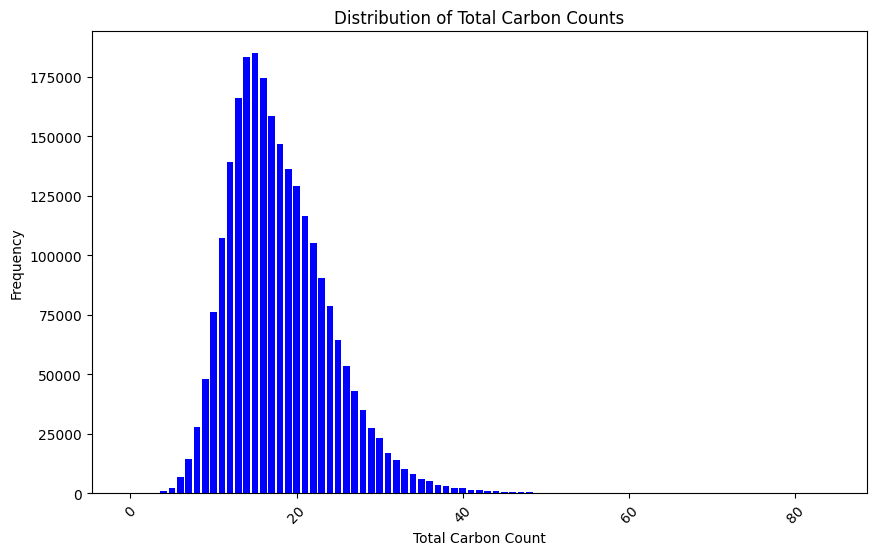

In [15]:
carbon_counts = train['Total Carbon']

# Count the frequency of each unique carbon count
carbon_count_freq = carbon_counts.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(carbon_count_freq.index, carbon_count_freq.values, color='blue')
plt.xlabel('Total Carbon Count')
plt.ylabel('Frequency')
plt.title('Distribution of Total Carbon Counts')
plt.xticks(rotation=45)
plt.show()



**Deep Analysis of Image Resolution**

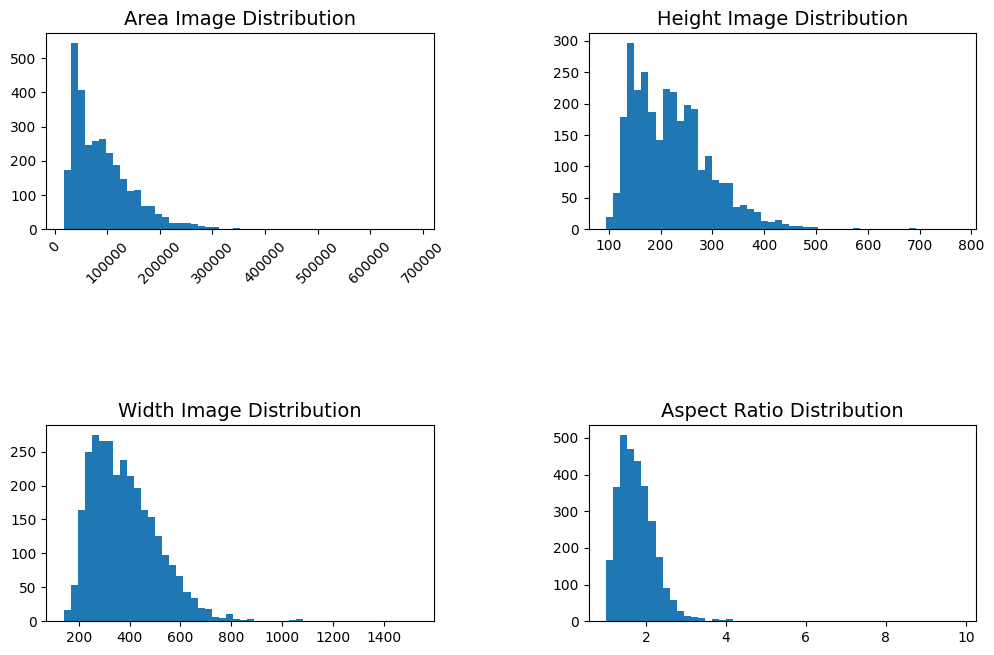

In [17]:

def analyze_image_shapes_and_aspect_ratios(image_paths, limit=3000):
    h_shapes = []
    w_shapes = []
    aspect_ratios = []

    for idx, image_path in enumerate(image_paths[:limit]):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h_shapes.append(image.shape[0])
        w_shapes.append(image.shape[1])
        aspect_ratios.append(1.0 * (image.shape[1] / image.shape[0]))

    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(top=0.5, bottom=0.01, hspace=1, wspace=0.4)

    plt.subplot(2, 2, 1)
    plt.hist(np.array(h_shapes) * np.array(w_shapes), bins=50)
    plt.xticks(rotation=45)
    plt.title("Area Image Distribution", fontsize=14)

    plt.subplot(2, 2, 2)
    plt.hist(h_shapes, bins=50)
    plt.title("Height Image Distribution", fontsize=14)

    plt.subplot(2, 2, 3)
    plt.hist(w_shapes, bins=50)
    plt.title("Width Image Distribution", fontsize=14)

    plt.subplot(2, 2, 4)
    plt.hist(aspect_ratios, bins=50)
    plt.title("Aspect Ratio Distribution", fontsize=14)

    plt.show()


image_paths = train['image_path'].values
analyze_image_shapes_and_aspect_ratios(image_paths, limit=3000)


****

**Denoise and Preprocessing**

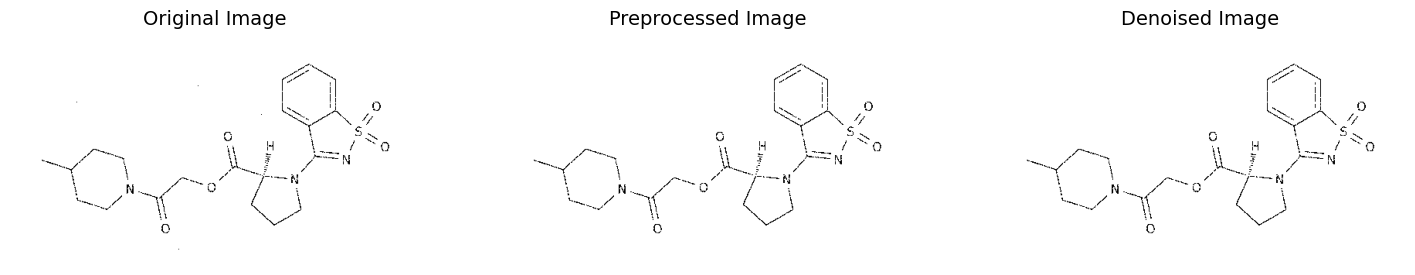

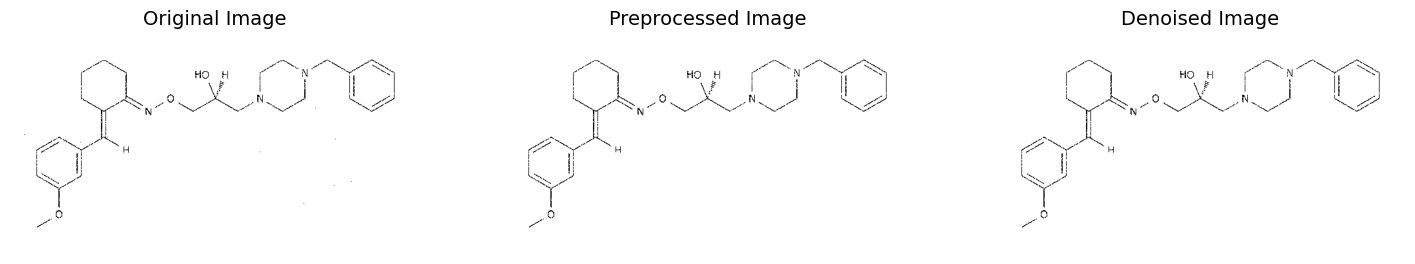

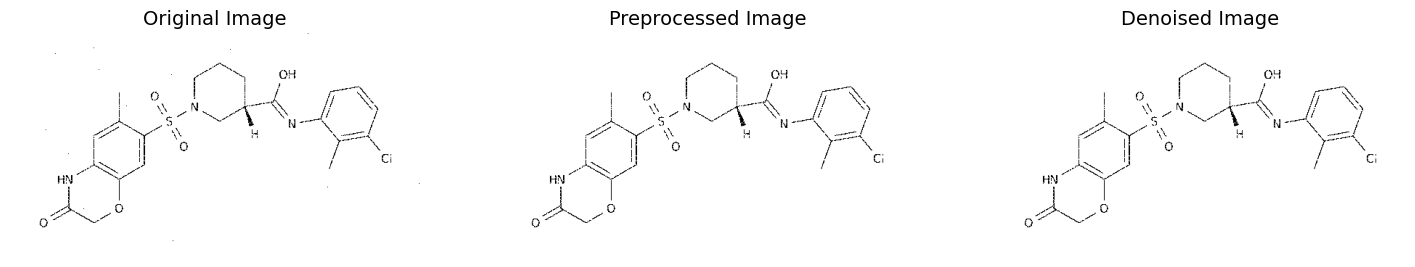

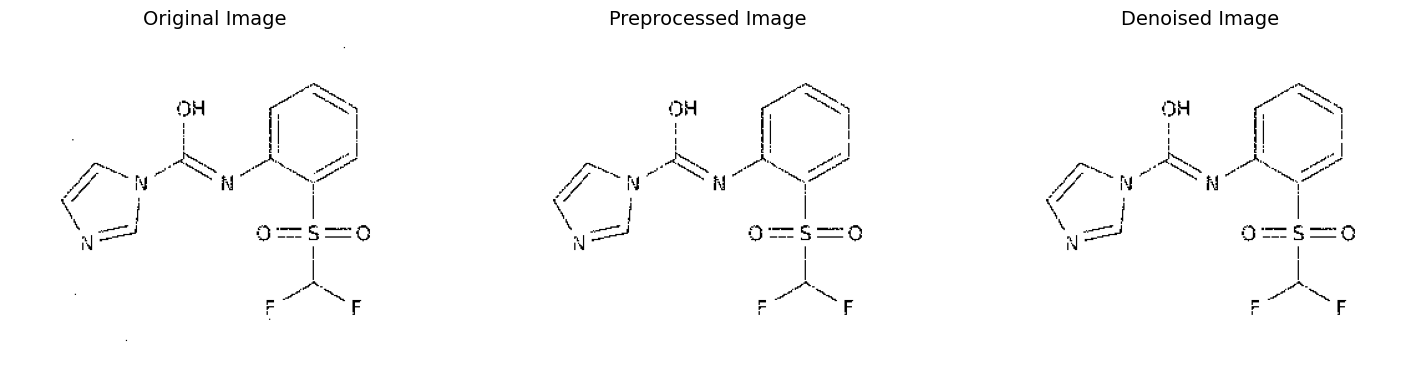

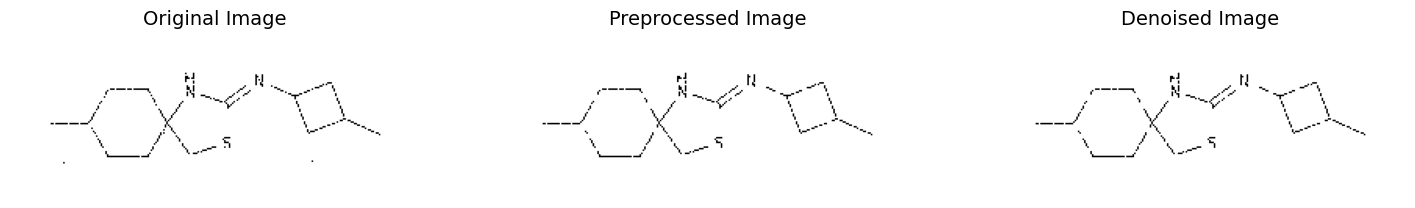

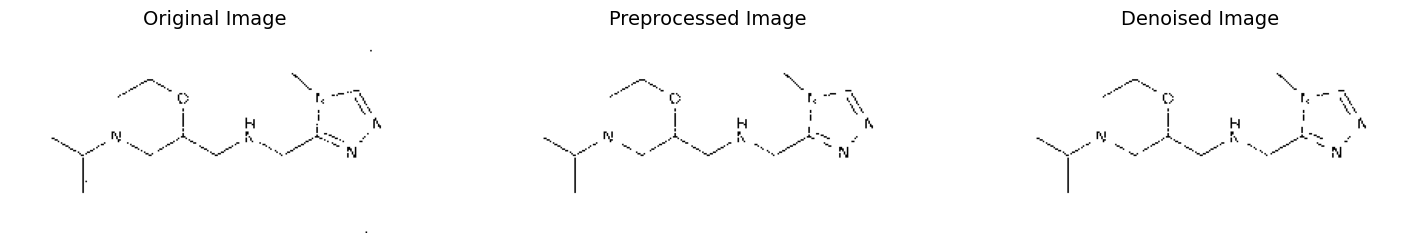

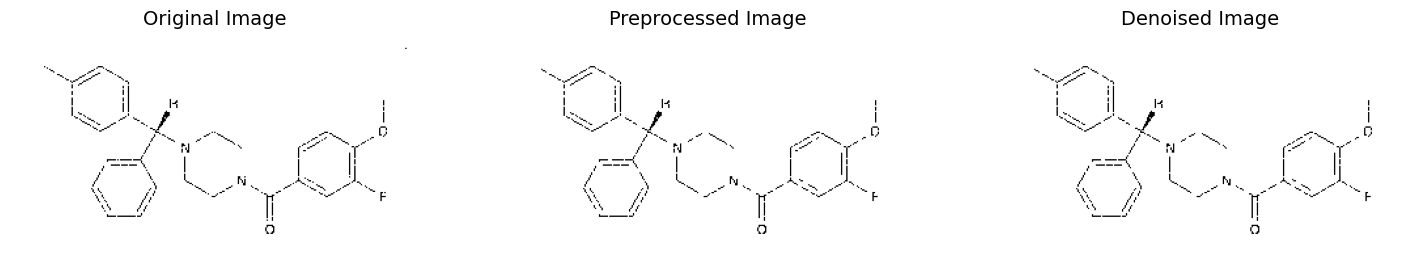

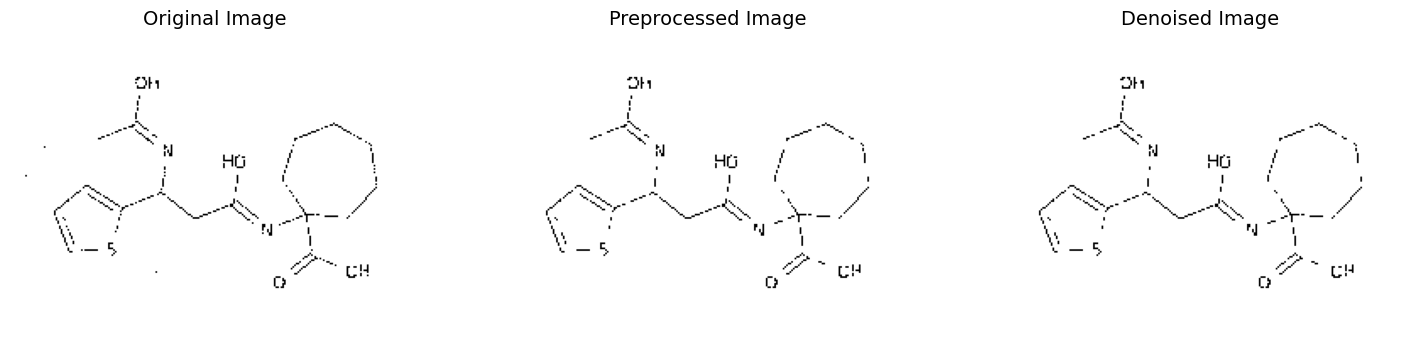

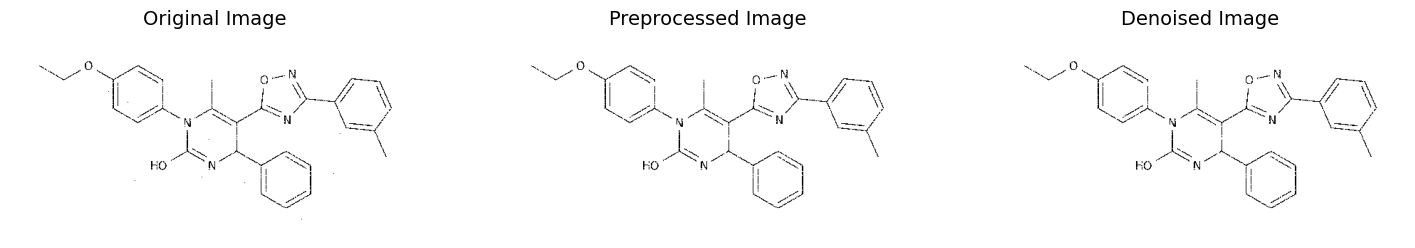

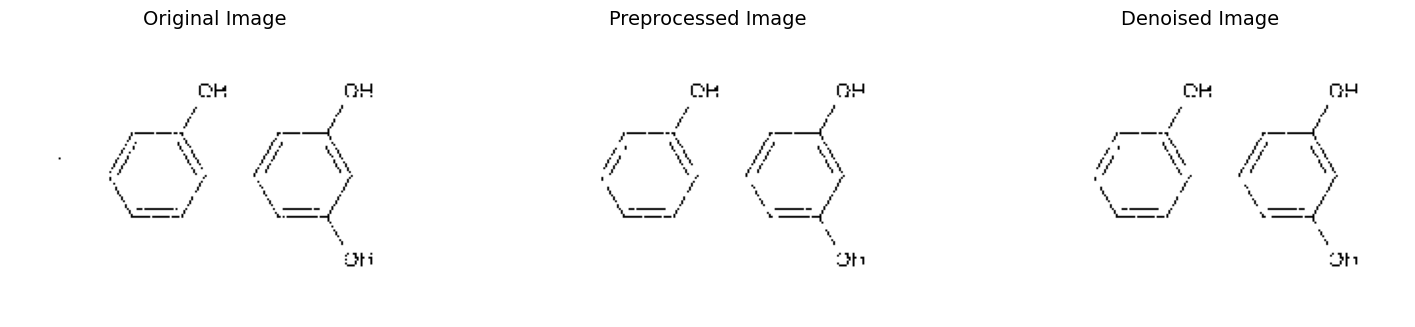

In [20]:

def remove_dots_and_noise(image):
    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # Find connected components and filter small dotted regions
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, None, None, None, 8, cv2.CV_32S)

    sizes = stats[1:, -1]  # Get CC_STAT_AREA component
    img2 = np.zeros_like(labels, np.uint8)

    for i in range(0, nlabels - 1):
        if sizes[i] >= 2:   # Filter small dotted regions
            img2[labels == i + 1] = 255

    # Invert the binary mask
    result_image = cv2.bitwise_not(img2)

    return result_image

def load_and_preprocess_image(path):
    image = Image.open(path)
    image = np.array(image)

    if len(image.shape) == 3:
        # Convert to grayscale if the image has 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    preprocessed_image = remove_dots_and_noise(image)

    return preprocessed_image

# Limit the number of images to process (e.g., to the first 1000)
limit = 1000  # Process 1000 images
train_subset = train[:limit].copy()
train_subset['X'] = train_subset['image_path'].apply(load_and_preprocess_image)

# Randomly select and display 10 images from the 1000 processed images
sample_indices = random.sample(range(limit), 10)
for i in sample_indices:
    sample_image = train_subset['X'].iloc[i]

    # Load the original image separately for comparison
    original_image = cv2.imread(train['image_path'].iloc[i])

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_image, cmap='gray')
    plt.title('Preprocessed Image', fontsize=14)
    plt.axis('off')

    denoised_image = remove_dots_and_noise(sample_image)
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised Image', fontsize=14)
    plt.axis('off')

    plt.show()


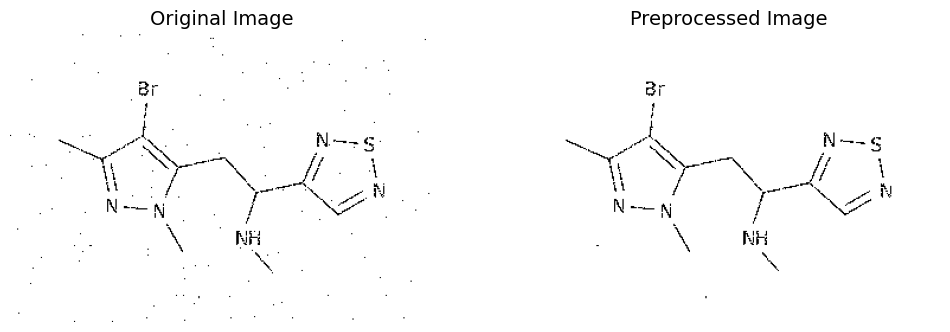

In [21]:
#  image path to test
image_path = '/kaggle/input/bms-molecular-translation/test/0/0/0/00000d2a601c.png'

# Load and preprocess the image
preprocessed_image = load_and_preprocess_image(image_path)

# Display the original and preprocessed images
original_image = cv2.imread(image_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image', fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image, cmap='gray')
plt.title('Preprocessed Image', fontsize=14)
plt.axis('off')

plt.show()


In [22]:
X = np.array(train_subset.X.values.tolist())
X.shape

/tmp/ipykernel_28/1753744002.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(train_subset.X.values.tolist())


(1000,)

**Model Building**

**Extracting features using DenseNet121**

In [68]:
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.models import Model

def get_features(train):
    # Load the DenseNet121 model
    model = DenseNet121()
    
    # Re-structure the model to remove the final classification layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # Create an empty dictionary to store features
    features = dict()
    
    # Iterate through image paths in the DataFrame
    for idx, name in enumerate(train_subset['image_path'].values[:1000]):
        filename = name
        
        try:
            # Load and preprocess the image using PIL
            image = Image.open(filename)
            image = image.resize((224, 224))
            image = np.array(image)
            
            # Check if the image is grayscale (single channel), and if so, convert it to RGB
            if len(image.shape) == 2:
                image = np.stack((image,) * 3, axis=-1)
            
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            
            # Extract features from the image using the model
            feature = model.predict(image, verbose=0)
            
            # Store the feature in the dictionary with the corresponding image_id
            features[train['image_id'][idx]] = feature
        except Exception as e:
            print(f"Error processing image {filename}: {e}") 
        
    return features


In [69]:
features =get_features(train)
print('Extracted Features: %d' % len(features))

33188688/33188688 [==============================] - 0s 0us/step
Extracted Features: 1000


In [70]:
def load_text_mappings(train, num_samples=1000):
    text_mapping = {}
    for idx, text in enumerate(train['InChI'].values[:num_samples]):
        image_id = train['image_id'][idx]
        text_mapping[image_id] = text
    return text_mapping

def create_vocabulary(text_mappings):
    vocabulary = set(text_mappings.values())
    return vocabulary

# Load text mappings from the DataFrame
text_mappings = load_text_mappings(train, num_samples=1000)

# Create a vocabulary from the loaded text mappings
vocabulary = create_vocabulary(text_mappings)

# Print the number of loaded text mappings and vocabulary size
print(f'Loaded: {len(text_mappings)} text mappings')
print(f'Vocabulary Size: {len(vocabulary)}')


Loaded: 1000 text mappings
Vocabulary Size: 1000


**** Calculate Mean Levenshtein distance****

In [26]:
def calculate_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    mean_score = np.mean(scores)
    return mean_score

In [27]:
y_true = train['InChI'].values
y_pred = [concatenated_inchi]  * len(train)
score = calculate_score(y_true, y_pred)
print(score)

80.56709427411923


In [71]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocabulary = {word: index for index, word in enumerate(text_mappings.values())}

# Step 1: Tokenize the InChI strings
tokenizer = Tokenizer(num_words=len(vocabulary), oov_token='<OOV>')  # Initialize the tokenizer
tokenizer.fit_on_texts(text_mappings.values())  # Fit the tokenizer on your text data
tokenized_sequences = tokenizer.texts_to_sequences(text_mappings.values())  # Tokenize the text data

# Step 2: Map tokens to integer IDs using the vocabulary
integer_sequences = [[vocabulary.get(token, 0) for token in sequence] for sequence in tokenized_sequences]

# Step 3: Determine the maximum sequence length
max_sequence_length = 100  # Define your desired maximum sequence length

# Step 4: Pad or truncate the sequences to the maximum sequence length
padded_sequences = pad_sequences(integer_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Now, 'padded_sequences' contains your tokenized sequences, padded or truncated to the maximum sequence length.

# Step 5: One-hot encode the tokenized sequences as your target data (y_train)
num_samples = len(padded_sequences)
vocab_size = len(vocabulary)

y_train = np.zeros((num_samples, max_sequence_length, vocab_size))
for i, sequence in enumerate(padded_sequences):
    for t, token_id in enumerate(sequence):
        if token_id != 0:  # Skip padding tokens (assuming 0 is the padding token)
            y_train[i, t, token_id] = 1  # Set the corresponding entry to 1



In [79]:
X_train = np.array([features[image_id] for image_id in train['image_id'].values[:num_samples]])
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:",y_train.shape)

Shape of X_train: (1000, 1, 1024)
Shape of y_train: (1000, 100, 1000)


**Spliting Dataset**

In [102]:
from sklearn.model_selection import train_test_split
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train[:52], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Reshape the data to the desired number of time steps
X_train = X_train[:, :seq_length, :]
X_val = X_val[:, :seq_length, :]
X_test = X_test[:, :seq_length, :]
y_train = y_train[:, :seq_length, :]
y_val = y_val[:, :seq_length, :]
y_test = y_test[:, :seq_length, :]


In [103]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

num_samples = min(X_train.shape[0], y_train.shape[0])
X_train = X_train[:num_samples]
y_train = y_train[:num_samples]

# Compile the model with the MSE loss function
model = Sequential()
model.add(LSTM(256, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit(X_train, y_train[:, :, 0], epochs=50, batch_size=32)
model.summary()

# Make predictions on your test data to generate y_pred
y_pred = model.predict(X_test)


Epoch 1/50
2/2 [==============================] - 3s 9ms/step - loss: 0.3976
Epoch 2/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1866
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.6493
Epoch 4/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1615
Epoch 5/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0290
Epoch 6/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1504
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.1380
Epoch 8/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0517
Epoch 9/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 11/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0326
Epoch 12/50
2/2 [==============================] - 0s 8ms/step - loss: 0.0383
Epoch 13/50
2/2 [==============================] - 0s 7ms/step - loss: 0.

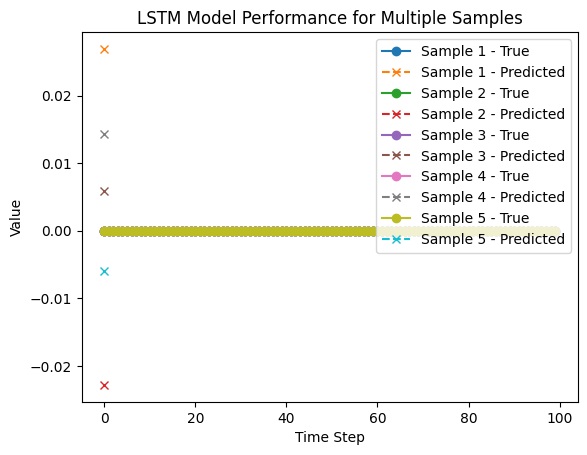

In [111]:
num_samples_to_visualize = 5 
for i in range(num_samples_to_visualize):
    true_values = y_test[i, :, 0]
    predicted_values = y_pred[i]
    plt.plot(true_values, label=f'Sample {i + 1} - True', marker='o')
    plt.plot(predicted_values, label=f'Sample {i + 1} - Predicted', linestyle='--', marker='x')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Model Performance for Multiple Samples')
plt.legend()
plt.show()


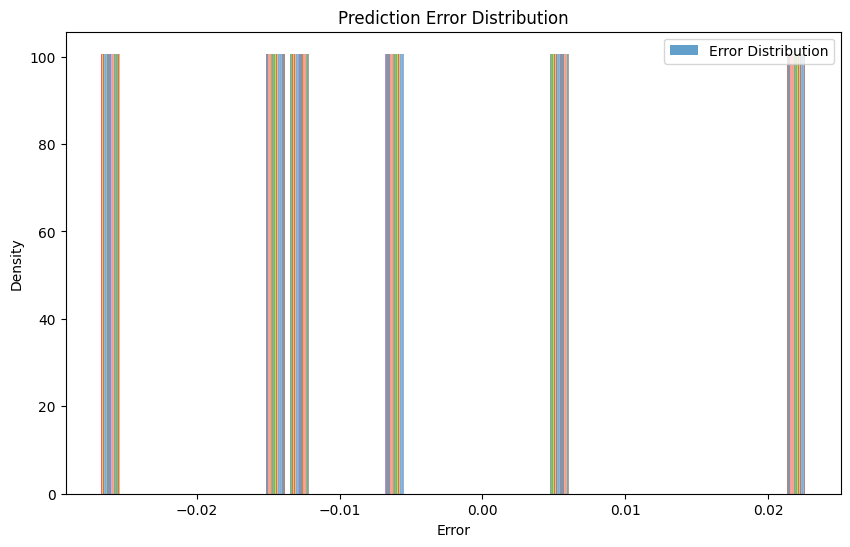

In [112]:
error = y_test[:, :, 0] - y_pred
plt.figure(figsize=(10, 6))
plt.hist(error, bins=30, density=True, alpha=0.7, label='Error Distribution')
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Prediction Error Distribution')
plt.legend()
plt.show()


**Mean Score LV**

In [108]:
y_true = train['InChI'].values
score = calculate_score(y_true, y_pred)
print(score)


128.33333333333334
